In [1]:
import findspark
findspark.init()

In [2]:
import pyspark

In [3]:
spark = pyspark.sql.SparkSession.builder.master('local').getOrCreate()

# Korean document version 

In [4]:
linesDF = spark.read \
        .format('csv') \
        .option('encoding', 'EUC-kr') \
        .option('header', 'False') \
        .option('sep', '\n') \
        .load('MisCurriculum.txt')

In [5]:
linesDF.take(3)

[Row(_c0='현대경영과기업가정신[(구)경영학원론]'),
 Row(_c0='(Contemporary Business and Entrepreurship)'),
 Row(_c0='자유자본주의 체제하에서의 기업경영과 관련된 전반적 개념을 연구한다. 구체적으로 경영환경을 포함하여 경영활동의 계획, 집행 및 통제기법과 그 밖에 개인 및 집단행동, 조직구조 등과 관련된 기초 원리를 연구한다. ')]

In [6]:
import re

In [7]:
# transformation lines to RDD
linesRDD = linesDF.rdd

In [8]:
wcRDD = linesRDD.map(lambda line: line[0]) \
        .flatMap(lambda line : re.split('\\W+', line)) \
        .filter(lambda word : len(word)>0) \
        .map(lambda word : (word,1)) \
        .reduceByKey(lambda v, w : v+w) \
        .sortBy(lambda vw : vw[1], False) \

In [9]:
# transformation RDD to DF
wcDF = spark.createDataFrame(wcRDD)

In [10]:
wcDF.printSchema()

root
 |-- _1: string (nullable = true)
 |-- _2: long (nullable = true)



In [11]:
wcDF.show(3)

+--------+---+
|      _1| _2|
+--------+---+
|      및| 41|
|학습한다| 15|
|Business| 14|
+--------+---+
only showing top 3 rows



In [12]:
import pyspark.sql.functions as F

In [13]:
wcDFnamed = wcDF.withColumnRenamed('_1', 'words')\
                 .withColumnRenamed('_2', 'freq')

In [14]:
wcDFnamed.printSchema()

root
 |-- words: string (nullable = true)
 |-- freq: long (nullable = true)



In [15]:
wcDFnamed.show(3)

+--------+----+
|   words|freq|
+--------+----+
|      및|  41|
|학습한다|  15|
|Business|  14|
+--------+----+
only showing top 3 rows



In [16]:
wcDFlength = wcDFnamed.withColumn('wordLen', F.length('words'))

In [17]:
wcDFlength.show(3)

+--------+----+-------+
|   words|freq|wordLen|
+--------+----+-------+
|      및|  41|      1|
|학습한다|  15|      4|
|Business|  14|      8|
+--------+----+-------+
only showing top 3 rows



In [18]:
wcDFlength.filter(wcDFlength.wordLen >= 1).show()

+----------+----+-------+
|     words|freq|wordLen|
+----------+----+-------+
|        및|  41|      1|
|  학습한다|  15|      4|
|  Business|  14|      8|
|      등을|  13|      2|
|      대한|  12|      2|
|      분석|  11|      2|
|        수|  11|      1|
|      이를|  11|      2|
|Management|  11|     10|
|  공부한다|  10|      4|
|    다양한|   9|      3|
|      위해|   9|      2|
|      한다|   9|      2|
|        IT|   9|      2|
|       and|   8|      3|
|        본|   8|      1|
|  목적으로|   8|      4|
|    이론을|   8|      3|
|        등|   8|      1|
|    디지털|   8|      3|
+----------+----+-------+
only showing top 20 rows



In [19]:
# agg function and show average using 'F.avg'
wordLengthFrequency = wcDFlength\
                     .groupby(F.col('wordLen'))\
                     .agg(F.count(F.col('freq')), F.avg(F.col('freq')))\
                     .orderBy(F.col('wordLen'))

In [20]:
wordLengthFrequency.show()

+-------+-----------+------------------+
|wordLen|count(freq)|         avg(freq)|
+-------+-----------+------------------+
|      1|         23| 4.130434782608695|
|      2|        197|2.1319796954314723|
|      3|        308|1.4545454545454546|
|      4|        216|1.4953703703703705|
|      5|        128|         1.2109375|
|      6|         53| 1.320754716981132|
|      7|         31|1.1935483870967742|
|      8|         22|1.9090909090909092|
|      9|         13|1.2307692307692308|
|     10|         15|1.7333333333333334|
|     11|          8|             1.625|
|     12|          6|1.1666666666666667|
|     13|          4|               1.0|
|     14|          2|               1.0|
+-------+-----------+------------------+



In [21]:
# plus argument 'F.sum'
wordLengthFrequency2 = wcDFlength\
                     .groupby(F.col('wordLen'))\
                     .agg(F.count(F.col('freq')), F.avg(F.col('freq')), F.sum(F.col('freq')))\
                     .orderBy(F.col('wordLen'))

In [22]:
wordLengthFrequency2.show()

+-------+-----------+------------------+---------+
|wordLen|count(freq)|         avg(freq)|sum(freq)|
+-------+-----------+------------------+---------+
|      1|         23| 4.130434782608695|       95|
|      2|        197|2.1319796954314723|      420|
|      3|        308|1.4545454545454546|      448|
|      4|        216|1.4953703703703705|      323|
|      5|        128|         1.2109375|      155|
|      6|         53| 1.320754716981132|       70|
|      7|         31|1.1935483870967742|       37|
|      8|         22|1.9090909090909092|       42|
|      9|         13|1.2307692307692308|       16|
|     10|         15|1.7333333333333334|       26|
|     11|          8|             1.625|       13|
|     12|          6|1.1666666666666667|        7|
|     13|          4|               1.0|        4|
|     14|          2|               1.0|        2|
+-------+-----------+------------------+---------+



In [23]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
x = wordLengthFrequency2.select(F.col('wordLen')).collect()

In [25]:
xA = np.array(x)

In [26]:
# transform 1 dimension using 'ravel' fun
xA1 = np.ravel(xA)

In [27]:
y = wordLengthFrequency2.select(F.col('count(freq)')).collect()

In [28]:
xB = np.array(y)

In [29]:
xB1 = np.ravel(xB)

No handles with labels found to put in legend.


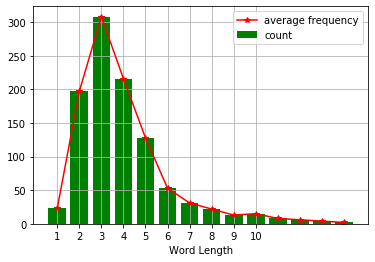

In [30]:
plt.bar(xA1, xB1, color='green')
plt.plot(xA1, xB1, marker='*' , color='red')
plt.legend()
plt.xlabel('Word Length')
plt.xticks(range(1,11))
plt.grid(True)
plt.legend(['average frequency', 'count'])
plt.show()

# English document version

In [31]:
linesDF_E = spark.read \
        .format('csv') \
        .option('encoding', 'EUC-kr') \
        .option('header', 'False') \
        .option('sep', '\n') \
        .load('t_bbe.csv')

In [32]:
linesDF_E.take(5)

[Row(_c0='field,field,field,field,field'),
 Row(_c0='"01001001","1","1","1","At the first God made the heaven and the earth."'),
 Row(_c0='"01001002","1","1","2","And the earth was waste and without form; and it was dark on the face of the deep: and the Spirit of God was moving on the face of the waters."'),
 Row(_c0='"01001003","1","1","3","And God said, Let there be light: and there was light."'),
 Row(_c0='"01001004","1","1","4","And God, looking on the light, saw that it was good: and God made a division between the light and the dark,"')]

In [33]:
# transformation lines to RDD
linesRDD_E = linesDF_E.rdd

In [34]:
wcRDD_E = linesRDD_E.map(lambda line: line[0]) \
        .flatMap(lambda line : re.split('\\W+', line)) \
        .filter(lambda word : len(word)>0) \
        .map(lambda word : (word,1)) \
        .reduceByKey(lambda v, w : v+w) \
        .sortBy(lambda vw : vw[1], False) \

In [35]:
# transformation RDD to DF
wcDF_E = spark.createDataFrame(wcRDD_E)

In [36]:
wcDF_E.printSchema()

root
 |-- _1: string (nullable = true)
 |-- _2: long (nullable = true)



In [37]:
wcDF_E.show(3)

+---+-----+
| _1|   _2|
+---+-----+
|the|63800|
| of|37714|
|and|33405|
+---+-----+
only showing top 3 rows



In [38]:
wcDF_E_named = wcDF_E.withColumnRenamed('_1', 'words')\
                 .withColumnRenamed('_2', 'freq')

In [39]:
wcDF_E_named.show(3)

+-----+-----+
|words| freq|
+-----+-----+
|  the|63800|
|   of|37714|
|  and|33405|
+-----+-----+
only showing top 3 rows



In [40]:
wcDF_E_length = wcDF_E_named.withColumn('wordLen', F.length('words'))

In [41]:
wcDF_E_length.show(3)

+-----+-----+-------+
|words| freq|wordLen|
+-----+-----+-------+
|  the|63800|      3|
|   of|37714|      2|
|  and|33405|      3|
+-----+-----+-------+
only showing top 3 rows



In [42]:
wcDF_E_length.filter(wcDF_E_length.wordLen >= 1).show()

+-----+-----+-------+
|words| freq|wordLen|
+-----+-----+-------+
|  the|63800|      3|
|   of|37714|      2|
|  and|33405|      3|
|   to|26327|      2|
|   in|14782|      2|
|  you|12231|      3|
|  And|11577|      3|
| will|10596|      4|
|    a|10436|      1|
|  for|10327|      3|
|   is|10127|      2|
|  his| 9257|      3|
|   be| 8972|      2|
|   he| 8500|      2|
|    I| 7811|      1|
| your| 7655|      4|
| Lord| 7633|      4|
|   on| 6890|      2|
| have| 6890|      4|
|  him| 6119|      3|
+-----+-----+-------+
only showing top 20 rows



In [43]:
# plus argument 'F.sum'
wordLengthFrequency_E = wcDF_E_length\
                     .groupby(F.col('wordLen'))\
                     .agg(F.count(F.col('freq')), F.avg(F.col('freq')), F.sum(F.col('freq')))\
                     .orderBy(F.col('wordLen'))

In [64]:
wordLengthFrequency_E.show(20)

+-------+-----------+------------------+---------+
|wordLen|count(freq)|         avg(freq)|sum(freq)|
+-------+-----------+------------------+---------+
|      1|         15|            3467.0|    52005|
|      2|        169|1363.4674556213017|   230426|
|      3|        351| 717.4843304843305|   251837|
|      4|        817|232.86658506731945|   190252|
|      5|       1265| 72.68695652173913|    91949|
|      6|       1358| 37.24889543446245|    50584|
|      7|       1144|  32.5979020979021|    37292|
|      8|      31874| 1.604787601179645|    51151|
|      9|        521|18.927063339731287|     9861|
|     10|        271|14.118081180811808|     3826|
|     11|        116|18.594827586206897|     2157|
|     12|         39| 9.128205128205128|      356|
|     13|         10|              41.7|      417|
|     14|          3|32.333333333333336|       97|
|     15|          3|              11.0|       33|
|     17|          1|               1.0|        1|
+-------+-----------+----------

In [45]:
a = wordLengthFrequency_E.select(F.col('wordLen')).collect()
b = wordLengthFrequency_E.select(F.col('count(freq)')).collect()

In [46]:
A = np.array(a)
B = np.array(b)

In [47]:
A1 = np.ravel(xA)
B1 = np.ravel(xB)

No handles with labels found to put in legend.


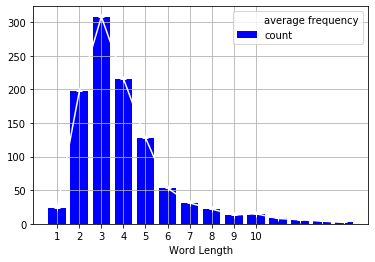

In [48]:
# visualization
plt.bar(A1, B1, color='blue')
plt.plot(A1, B1, marker='+' , color='white')
plt.legend()
plt.xlabel('Word Length')
plt.xticks(range(1,11))
plt.grid(True)
plt.legend(['average frequency', 'count'])
plt.show()

In [49]:
top20Words=linesRDD.map(lambda line: line[0]) \
        .flatMap(lambda line : re.split('\\W+', line)) \
        .filter(lambda word : len(word)>0) \
        .map(lambda word : (word,1)) \
        .reduceByKey(lambda v, w : v+w) \
        .sortBy(lambda vw : vw[1], False) \
        .take(20)

In [50]:
top20Words

[('및', 41),
 ('학습한다', 15),
 ('Business', 14),
 ('등을', 13),
 ('대한', 12),
 ('분석', 11),
 ('수', 11),
 ('이를', 11),
 ('Management', 11),
 ('공부한다', 10),
 ('다양한', 9),
 ('위해', 9),
 ('한다', 9),
 ('IT', 9),
 ('and', 8),
 ('본', 8),
 ('목적으로', 8),
 ('이론을', 8),
 ('등', 8),
 ('디지털', 8)]

In [51]:
SQL_top20Words = wcDFlength.filter(wcDFlength.wordLen >= 1)

In [52]:
SQL_top20Words.show()

+----------+----+-------+
|     words|freq|wordLen|
+----------+----+-------+
|        및|  41|      1|
|  학습한다|  15|      4|
|  Business|  14|      8|
|      등을|  13|      2|
|      대한|  12|      2|
|      분석|  11|      2|
|        수|  11|      1|
|      이를|  11|      2|
|Management|  11|     10|
|  공부한다|  10|      4|
|    다양한|   9|      3|
|      위해|   9|      2|
|      한다|   9|      2|
|        IT|   9|      2|
|       and|   8|      3|
|        본|   8|      1|
|  목적으로|   8|      4|
|    이론을|   8|      3|
|        등|   8|      1|
|    디지털|   8|      3|
+----------+----+-------+
only showing top 20 rows



In [53]:
x = []
y = []
for (w , c) in top20Words:
    x.append(w)
    y.append(c)

In [54]:
from matplotlib import font_manager
fontpath = '/home/tteon/바탕화면/NanumBarunGothic.ttf'
fontprop = font_manager.FontProperties(fname=fontpath)

In [55]:
plt.bar(x,y)
plt.title('wordscount_visualization_barsection')
plt.xlabel('wordcount', color='blue')
plt.ylabel('volume' , color='gray')
plt.grid(True)
plt.xticks(rotation='vertical', fontproperties=fontprop)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/tteon/바탕화면/NanumBarunGothic.ttf'

<Figure size 432x288 with 1 Axes>

In [56]:
top20Words_E=linesRDD_E.map(lambda line: line[0]) \
            .flatMap(lambda line : re.split('\\W+', line)) \
            .filter(lambda word : len(word)>0) \
            .map(lambda word : (word,1)) \
            .reduceByKey(lambda v, w : v+w) \
            .sortBy(lambda vw : vw[1], False) \
            .take(20)

In [57]:
top20Words_E

[('the', 63800),
 ('of', 37714),
 ('and', 33405),
 ('to', 26327),
 ('in', 14782),
 ('you', 12231),
 ('And', 11577),
 ('will', 10596),
 ('a', 10436),
 ('for', 10327),
 ('is', 10127),
 ('his', 9257),
 ('be', 8972),
 ('he', 8500),
 ('I', 7811),
 ('your', 7655),
 ('Lord', 7633),
 ('on', 6890),
 ('have', 6890),
 ('him', 6119)]

In [58]:
SQL_top20words_E = wcDF_E_length.filter(wcDF_E_length.wordLen >= 1).show()

+-----+-----+-------+
|words| freq|wordLen|
+-----+-----+-------+
|  the|63800|      3|
|   of|37714|      2|
|  and|33405|      3|
|   to|26327|      2|
|   in|14782|      2|
|  you|12231|      3|
|  And|11577|      3|
| will|10596|      4|
|    a|10436|      1|
|  for|10327|      3|
|   is|10127|      2|
|  his| 9257|      3|
|   be| 8972|      2|
|   he| 8500|      2|
|    I| 7811|      1|
| your| 7655|      4|
| Lord| 7633|      4|
|   on| 6890|      2|
| have| 6890|      4|
|  him| 6119|      3|
+-----+-----+-------+
only showing top 20 rows



In [59]:
import pandas

In [60]:
SQL_top20words_E = wcDF_E_length.filter(wcDF_E_length.wordLen >= 1)

In [65]:
SQL_top20words_E.head(20)

[Row(words='the', freq=63800, wordLen=3),
 Row(words='of', freq=37714, wordLen=2),
 Row(words='and', freq=33405, wordLen=3),
 Row(words='to', freq=26327, wordLen=2),
 Row(words='in', freq=14782, wordLen=2),
 Row(words='you', freq=12231, wordLen=3),
 Row(words='And', freq=11577, wordLen=3),
 Row(words='will', freq=10596, wordLen=4),
 Row(words='a', freq=10436, wordLen=1),
 Row(words='for', freq=10327, wordLen=3),
 Row(words='is', freq=10127, wordLen=2),
 Row(words='his', freq=9257, wordLen=3),
 Row(words='be', freq=8972, wordLen=2),
 Row(words='he', freq=8500, wordLen=2),
 Row(words='I', freq=7811, wordLen=1),
 Row(words='your', freq=7655, wordLen=4),
 Row(words='Lord', freq=7633, wordLen=4),
 Row(words='on', freq=6890, wordLen=2),
 Row(words='have', freq=6890, wordLen=4),
 Row(words='him', freq=6119, wordLen=3)]

In [62]:
SQL_frequency_2 = SQL_top20words_E.df['freq']

AttributeError: 'DataFrame' object has no attribute 'df'

In [ ]:
print(type(SQL_frequency_2))

In [ ]:
SQL_frequency_2

In [ ]:
for bb1 in SQL_frequency_2:
    bb.append(bb1)

In [ ]:
bb

In [ ]:
print(type(SQL_frequency))

In [ ]:
SQL_frequency.head()

In [ ]:
type(b)

In [ ]:
a = []
b = []

In [ ]:
for (w , c) in top20Words_E:
    a.append(w)
    b.append(c)

In [ ]:
plt.bar(a,b)
plt.title('bible_frequency')
plt.xlabel('wordcount', color='blue')
plt.ylabel('volume' , color='gray')
plt.grid(True)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
plt.plot(a,b)
plt.title('bible_frequency')
plt.xlabel('wordcount', color= 'gray')
plt.ylabel('volume' , color = 'blue')
plt.grid(True)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
plt.figure(1)
plt.bar(a,b)
plt.title('bible_frequency')
plt.xlabel('wordcount', color='blue')
plt.ylabel('volume' , color='gray')
plt.grid(True)
plt.xticks(rotation='vertical')
plt.show()

plt.figure(2)
plt.bar(x,y)
plt.title('wordscount_visualization_barsection')
plt.xlabel('wordcount', color='blue')
plt.ylabel('volume' , color='gray')
plt.grid(True)
plt.xticks(rotation='vertical', fontproperties=fontprop)
plt.show()

plt.figure(3)
plt.bar(xA1, xB1, color='green')
plt.plot(xA1, xB1, marker='*' , color='red')
plt.legend()
plt.xlabel('Word Length')
plt.xticks(range(1,11))
plt.grid(True)
plt.legend(['average frequency', 'count'])
plt.show()

plt.figure(4)
plt.bar(A1, B1, color='blue')
plt.plot(A1, B1, marker='+' , color='white')
plt.legend()
plt.xlabel('Word Length')
plt.xticks(range(1,11))
plt.grid(True)
plt.legend(['average frequency', 'count'])
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(a, b)
axs[0, 0].set_title('original_english')
axs[0, 1].plot(A1, B1, 'tab:orange')
axs[0, 1].set_title('SQL_english')
axs[1, 0].plot(x, y, 'tab:green')
axs[1, 0].set_title('original_korean')
axs[1, 1].plot(xA1, xB1, 'tab:red')
axs[1, 1].set_title('SQL_korean')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
